In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
beta_0 = 0.4
beta_inf = 0.1
T = 20
tau = 5


def beta_fn(t, n):
    # The arguments of this function are "t" -- the current simulation day,

    # and "n" the current geo node.

    # This formuluation allows us to vary the parameter over time and geo node.
    if 0 <= t <= T:
        return beta_0

    elif t > T:
        return beta_inf + (beta_0 - beta_inf) * math.exp(-(t - T) / tau)

    return None

In [3]:
# from functools import partial

from epymorph import *  # noqa: F403
from epymorph.adrio import acs5, commuting_flows
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.seir import Seir
from epymorph.data.mm.pei import Pei
# from epymorph.initializer import LabeledLocations
# from epymorph.initializer import explicit, single_location

scope = StateScope.in_states(["AZ", "NM", "CO"], year=2015)
n_nodes = len(scope.includes)
initial_state = np.zeros(shape=(n_nodes, 4), dtype=np.int64)
initial_state[:, 0] = 100_000 - 10
initial_state[:, 1] = 20

rume = SingleStrataRume.build(
    # Load an IPM from the library
    ipm=Seir(),
    # Load an MM from the library
    mm=Pei(),
    # Use our scope
    scope=scope,
    init=init.Explicit(initials=initial_state),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2015-01-01", 120),
    # Provide parameter values
    params={
        "beta": 0.4,
        "eta": 1 / 7,
        "gamma": 1 / 14,
        "q": 0.1,
        # Geographic data can be loaded using ADRIOs
        "population": acs5.Population(),
        "commuters": commuting_flows.Commuters(),
        # "commuters": c
    },
)


sim = BasicSimulator(rume)

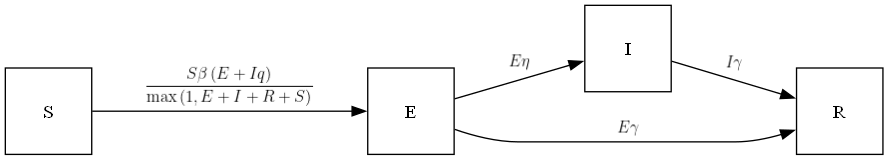

In [4]:
render(rume.ipm)

In [5]:
scope

StateScope(year=2015, granularity='state', includes_granularity='state', includes=('04', '08', '35'), _node_ids=array(['04', '08', '35'], dtype='<U2'))

In [ ]:
from epymorph.simulator.data import evaluate_param

params = {}

for key in rume.params:
    params[key] = np.array(evaluate_param(rume, str(key)))

In [7]:
rume_copy = SingleStrataRume(
    strata=rume.strata,
    ipm=rume.ipm,
    mms=rume.mms,
    scope=rume.scope,
    time_frame=rume.time_frame,
    params=params,
)

In [8]:
sim = BasicSimulator(rume_copy)

In [9]:
with sim_messaging():
    out = sim.run()

Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-01 (120 days)
• 3 geo nodes
  |####################| 100% 
Runtime: 0.195s


In [10]:
sim.rume.params[list(sim.rume.params.keys())[-1]]

array([[2730296,    1233,    3219],
       [   1358, 2572153,    2764],
       [   2285,    2189,  843776]], dtype=int64)

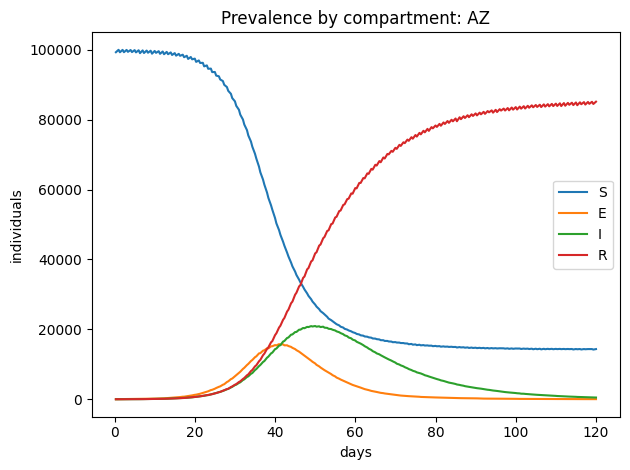

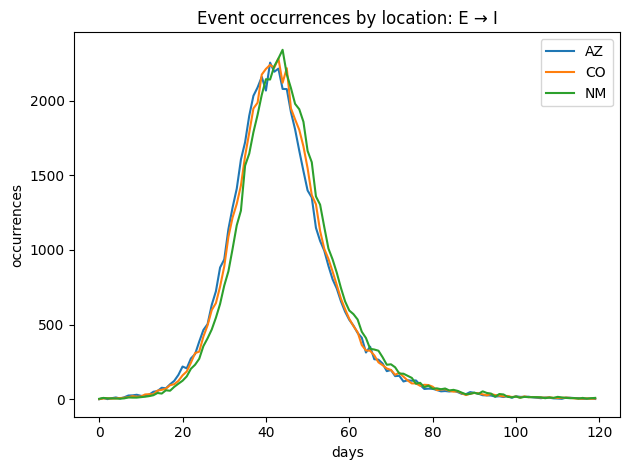

In [11]:
plot_pop(out, 0)  # prevalence for all compartments in population 0.
plot_event(out, 1)  # incidence data for the E->I event across all populations.

In [12]:
out.incidence_per_day[-1, ...][:, 1]

array([2, 5, 9], dtype=int64)

In [13]:
out.prevalence.shape

(240, 3, 4)

In [14]:
cases = out.incidence_per_day[:, :, 1]

In [15]:
cases.shape

(120, 3)

In [16]:
rng = np.random.default_rng()

sim_data = rng.poisson(cases)
sim_data

array([[   0,    3,    5],
       [   7,    8,   10],
       [   1,    9,    7],
       [   7,    3,    5],
       [   8,    7,    4],
       [   3,    6,    6],
       [  14,   13,    3],
       [  21,   16,   18],
       [  31,   23,    4],
       [  39,   18,    7],
       [  24,   12,   16],
       [  27,   35,   18],
       [  33,   29,   16],
       [  55,   24,   27],
       [  62,   66,   47],
       [  94,   54,   31],
       [  69,   93,   57],
       [  87,  103,   57],
       [ 125,   90,   62],
       [ 173,  128,  113],
       [ 207,  159,  120],
       [ 203,  186,  133],
       [ 303,  230,  215],
       [ 288,  308,  220],
       [ 383,  297,  294],
       [ 469,  416,  327],
       [ 488,  518,  385],
       [ 599,  573,  442],
       [ 703,  644,  603],
       [ 888,  766,  617],
       [ 922,  899,  736],
       [1118, 1100,  823],
       [1294, 1242, 1036],
       [1446, 1385, 1158],
       [1654, 1455, 1264],
       [1708, 1601, 1559],
       [1869, 1808, 1621],
 

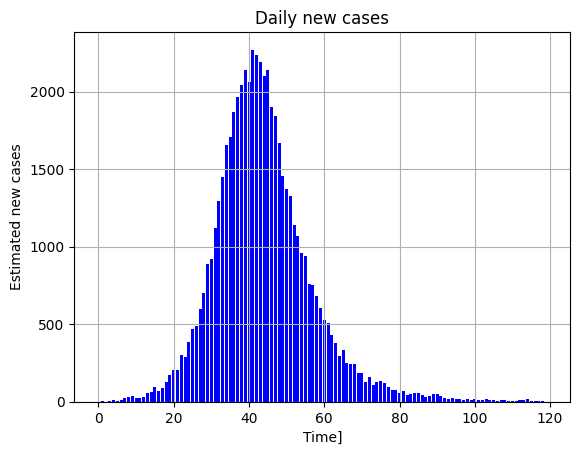

In [17]:
# Extract the values from column index 1
values = sim_data[:, 0]
# values = values.astype(int)

time_axis = range(len(values))

# Plot the values over time as a bar plot
plt.bar(time_axis, values, color="blue")
plt.xlabel("Time]")
plt.ylabel("Estimated new cases")
plt.title("Daily new cases")
plt.grid(True)
plt.show()

In [28]:
# Create a date range starting from 2015-01-01
start_date = pd.to_datetime("2015-01-01")
dates = pd.date_range(start=start_date, periods=len(values), freq="D")


# df_dict = {"Date": dates}

df = pd.concat(
    [
        pd.DataFrame({"Date": dates, "fips": scope.includes[i], "Cases": cases[:, 0]})
        for i in range(len(scope.includes))
    ],
    axis=0,
)

# df = pd.concat(dfs, axis=0)

# Save the DataFrame to a CSV file
df.to_csv("./synthetic_data_multinode.csv", index=False)

# Print the first few rows to verify
print(df)

          Date fips  Cases
0   2015-01-01   04      0
1   2015-01-02   04      8
2   2015-01-03   04      1
3   2015-01-04   04      7
4   2015-01-05   04     12
..         ...  ...    ...
115 2015-04-26   35      8
116 2015-04-27   35      2
117 2015-04-28   35      4
118 2015-04-29   35      5
119 2015-04-30   35      2

[360 rows x 3 columns]


In [22]:
df

,Date,fips,Cases
0,2015-01-01,35,0
1,2015-01-02,35,8
2,2015-01-03,35,1
3,2015-01-04,35,7
4,2015-01-05,35,12
...,...,...,...
115,2015-04-26,35,8
116,2015-04-27,35,2
117,2015-04-28,35,4
118,2015-04-29,35,5
